# Loading Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [2]:
from torchvision.datasets import MNIST

def get_dataset(train):
    data = MNIST('.', train=train, download=True)
    return data.data, data.targets

In [3]:
# get training and testing dataset
features, labels = get_dataset(train=True)
features_test, labels_test = get_dataset(train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
features = np.array(features)
number_of_training_data = len(features)
features_test = np.array(features_test)
number_of_testing_data = len(features_test)

print("Number of training data:", number_of_training_data)
print("Training data shape:", features.shape)
print("Number of testing data:", number_of_testing_data)
print("Testing data shape:", features_test.shape)

Number of training data: 60000
Training data shape: (60000, 28, 28)
Number of testing data: 10000
Testing data shape: (10000, 28, 28)


# Data preprocessing

In [5]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [7]:
resnet = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
step = 7

In [9]:
norm_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Feature Extraction

In [10]:
from math import copysign, log10, log1p

In [11]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    huMoments = cv2.HuMoments(cv2.moments(image)).flatten()
    for i in range(0,7):
        huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
    return huMoments

In [12]:
def feature_extraction(features, number_of_data):
    data = []
    t0 = time.time()

    for index, feature in enumerate(features):
        fv_hu_moments = fd_hu_moments(feature)
        data.append(fv_hu_moments)
    
    t1 = time.time()
    print("Feature extraction {} features - {:.0f}s".format(number_of_data, t1-t0))
    
    return data

# Classification

In [13]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [14]:
def image_processing(features, number_of_data, weight_index):
    features_normalized, features_processed = [], []
    t0 = time.time()

    # apply z score normalization
    for image in features:
        # convert grayscale to rgb
        image = torch.FloatTensor(image)
        image.unsqueeze_(0)
        image_rgb = image.repeat(3, 1, 1)
        
        # apply z score normalization
        image_norm = norm_transform(image_rgb)
        features_normalized.append(image_norm)
    
    # apply cnn
    loader = DataLoader(features_normalized, batch_size=number_of_data // step, shuffle=False)
    for images in loader:
        images = images.to(device)
        images_conv = resnet.conv1(images) # (batch_size, 64, 128, 128)
        images_conv = np.array([conv[weight_index].cpu().detach().numpy() for conv in images_conv])
        # images_conv = images_conv.mean(dim=(1)) # semua feature map di avg (batch_size, 128, 128)
        features_processed.append(images_conv)
    
    t1 = time.time()
    print("Image processing {} features - {:.0f}s".format(number_of_data, t1-t0))

    return np.vstack(features_processed)

In [15]:
accuracies = []
for weight_index in range(48, 64):
    tx = time.time()
    
    features_processed = image_processing(features, number_of_training_data, weight_index)
    features_test_processed = image_processing(features_test, number_of_testing_data, weight_index)

    data = feature_extraction(features_processed, number_of_training_data)
    target = labels

    data_test = feature_extraction(features_test_processed, number_of_testing_data)
    target_test = labels_test

    t0 = time.time()
    clf = svm.SVC(gamma=0.001, C=100.)
    clf.fit(data, target)
    print("Training - {:.0f}s".format(time.time()-t0))

    t0 = time.time()
    y_pred = clf.predict(data_test)
    y_test = target_test
    print("Prediction - {:.0f}s".format(time.time()-t0))
    
    accuracy = accuracy_score(y_test,y_pred)
    accuracies.append(accuracy)

    ty = time.time()
    print("================================================= filter : {} - accuracy : {:.2f}% - {:.0f}s".format(weight_index, accuracy*100, ty-tx))

Image processing 60000 features - 26s
Image processing 10000 features - 4s
Feature extraction 60000 features - 1s
Feature extraction 10000 features - 0s
Training - 314s
Prediction - 38s
================================================= filter : 48 - accuracy : 37.64% - 384s
Image processing 60000 features - 25s
Image processing 10000 features - 4s
Feature extraction 60000 features - 1s
Feature extraction 10000 features - 0s
Training - 465s
Prediction - 41s
================================================= filter : 49 - accuracy : 14.59% - 536s
Image processing 60000 features - 25s
Image processing 10000 features - 4s
Feature extraction 60000 features - 1s
Feature extraction 10000 features - 0s
Training - 395s
Prediction - 39s
================================================= filter : 50 - accuracy : 27.82% - 465s
Image processing 60000 features - 25s
Image processing 10000 features - 4s
Feature extraction 60000 features - 1s
Feature extraction 10000 features - 0s
Training - 398s
Predic

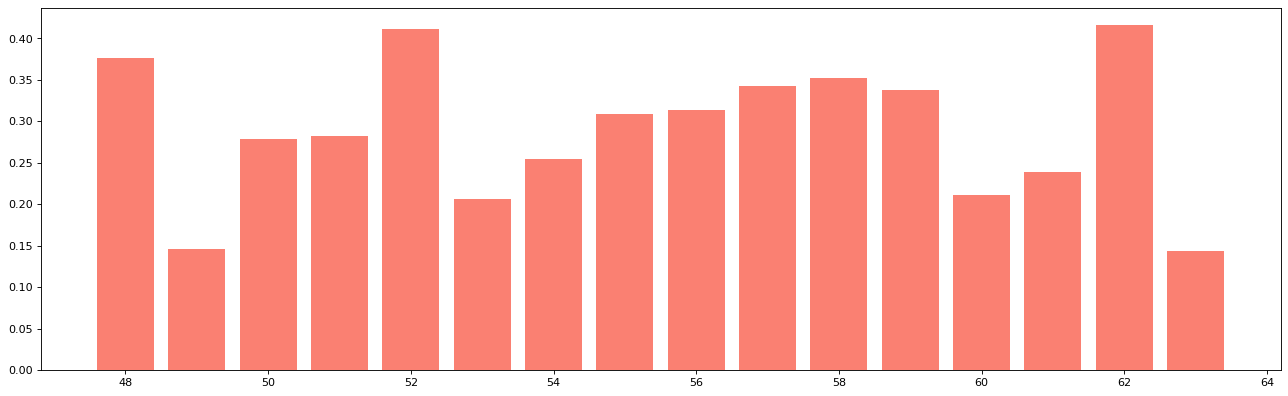

48 0.3764
49 0.1459
50 0.2782
51 0.2818
52 0.4117
53 0.2065
54 0.2541
55 0.3091
56 0.3132
57 0.3425
58 0.3522
59 0.3374
60 0.2112
61 0.2387
62 0.416
63 0.1437


In [16]:
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

x = range(48, 64)
y = accuracies

plt.bar(x, y, color='salmon')
plt.show()

for (i, j) in zip(x, y):
  print(i, j)